In [1]:
import nltk
nltk.download('punkt')
nltk.download('gutenberg')
from nltk.corpus import gutenberg
austen = gutenberg.sents('austen-sense.txt') + gutenberg.sents('austen-emma.txt') + gutenberg.sents('austen-persuasion.txt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


Sanity check:
This training corpus contains 16498 sentences. Use the line that follows to ensure that your code
has the same number of lines.


In [2]:
print(len(austen))

16498


2. Preprocessing the Training Corpus

In [3]:
print(austen)

[['[', 'Sense', 'and', 'Sensibility', 'by', 'Jane', 'Austen', '1811', ']'], ['CHAPTER', '1'], ...]


In [4]:
austen[0]

['[', 'Sense', 'and', 'Sensibility', 'by', 'Jane', 'Austen', '1811', ']']

TASK: Write code to remove special characters, empty strings, digits and
stopwords from the sentences and put all the words into lower cases.

In [5]:
import string
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

def corpus(austen):
  # empty list
  austen2 = []
  for a in austen:
    # Remove special char, empty string, digits and stopwords
    # all words in lowercase
    
    #join and Lowercase
    a = ' '.join(a).lower()

    #Special char  
    exclude = set(string.punctuation)
    a = ''.join(i for i in a if i not in exclude)
    # Digits
    a = re.sub(r'\d+', '', a)
    # Stopwords
    stop_words = set(stopwords.words('english'))
    from nltk.tokenize import word_tokenize
    tokens = word_tokenize(a)
    a = [i for i in tokens if (not i in stop_words) and (not i == '')]

    if a != []:
      austen2.append(' '.join(a))
      #print(a)

  #print(len(austen2))
  return austen2



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
corpus(austen)

['sense sensibility jane austen',
 'chapter',
 'family dashwood long settled sussex',
 'estate large residence norland park centre property many generations lived respectable manner engage general good opinion surrounding acquaintance',
 'late owner estate single man lived advanced age many years life constant companion housekeeper sister',
 'death happened ten years produced great alteration home supply loss invited received house family nephew mr henry dashwood legal inheritor norland estate person intended bequeath',
 'society nephew niece children old gentleman days comfortably spent',
 'attachment increased',
 'constant attention mr mrs henry dashwood wishes proceeded merely interest goodness heart gave every degree solid comfort age could receive cheerfulness children added relish existence',
 'former marriage mr henry dashwood one son present lady three daughters',
 'son steady respectable young man amply provided fortune mother large half devolved coming age',
 'marriage likewi

3. Creating the Corpus Vocabulary and Preparing the Dataset.

In [12]:
from keras.preprocessing.text import Tokenizer
a =  corpus(austen)
# Create Tokenizer
t = Tokenizer()
# fit tokenizer on documents
t.fit_on_texts(a)

#print(t.word_counts)
#print(t.document_count)
# word2inx
#print(t.word_index)
#print('Number of unique words:', len(t.word_index))

#word2ind
word2idx = t.word_index
print(list(word2idx.items())[:10])

#ind2word
idx2word = dict([(value,key) for key, value in t.word_index.items()])
print(list(idx2word.items())[:10])

# sents_as_ids
sents_as_ids = []
for i in a:
    #print(i)
    temp = i.split()
    #print(str(temp))
    sents_as_ids.append([word2idx[x] for x in temp])
    #print(sents_as_ids) 


print(sents_as_ids[:3])

vocab_size = len(word2idx) + 1 # 1 was added for zero padding
embed_size = 100

[('could', 1), ('would', 2), ('mr', 3), ('mrs', 4), ('must', 5), ('said', 6), ('one', 7), ('much', 8), ('miss', 9), ('every', 10)]
[(1, 'could'), (2, 'would'), (3, 'mr'), (4, 'mrs'), (5, 'must'), (6, 'said'), (7, 'one'), (8, 'much'), (9, 'miss'), (10, 'every')]
[[313, 1398, 76, 4338], [236], [112, 102, 60, 347, 2429]]


4. Generating training instances

In [0]:
from keras.preprocessing.sequence import skipgrams
skip_grams = [skipgrams(sent, vocabulary_size=vocab_size, window_size=5) for sent in
sents_as_ids]

In [0]:
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(len(pairs)):
  print('({:s} ({:d}), {:s} ({:d})) -> {:d}'.format(
  # the first word and its index
  idx2word[pairs[i][0]], pairs[i][0],
  # the second word and its index
  idx2word[pairs[i][1]], pairs[i][1],
  # the label
  labels[i]))

(sensibility (1398), jane (76)) -> 1
(austen (4338), sense (313)) -> 1
(austen (4338), lake (9604)) -> 0
(sense (313), unanswerable (4454)) -> 0
(sensibility (1398), fairest (5923)) -> 0
(sense (313), double (3058)) -> 0
(jane (76), producing (3325)) -> 0
(sense (313), austen (4338)) -> 1
(sensibility (1398), sense (313)) -> 1
(austen (4338), forenoon (5701)) -> 0
(sensibility (1398), shrink (5156)) -> 0
(jane (76), sense (313)) -> 1
(jane (76), sensibility (1398)) -> 1
(austen (4338), jane (76)) -> 1
(austen (4338), quieted (4369)) -> 0
(sense (313), sensibility (1398)) -> 1
(sense (313), jane (76)) -> 1
(sense (313), misapplied (7191)) -> 0
(austen (4338), sensibility (1398)) -> 1
(jane (76), repossessed (9904)) -> 0
(sensibility (1398), austen (4338)) -> 1
(jane (76), austen (4338)) -> 1
(sensibility (1398), betrayed (2045)) -> 0
(jane (76), subdued (2686)) -> 0


5. Building the Skip-gram Neural Network Architecture

In [0]:
from keras.layers import Dot, Input
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import plot_model

A. The first step is to initialize and transform the first input using the following lines of code:

In [0]:
target_word = Input((1,), dtype='int32')
target_embedding = Embedding(vocab_size, embed_size, name='target_embed_layer', embeddings_initializer='glorot_uniform', input_length=1)(target_word)
target_input = Reshape((embed_size, ))(target_embedding)

B. Write similar code for the ‘context_word’ input.

In [0]:
context_word = Input((1,), dtype='int32')
context_embedding = Embedding(vocab_size, embed_size, name='context_embed_layer', embeddings_initializer='glorot_uniform', input_length=1)(context_word)
context_input = Reshape((embed_size, ))(context_embedding)

C. Merge the inputs.

In [0]:
merged_inputs = Dot(axes=-1, normalize=False)([target_input, context_input])

D. Pass the merged inputs into sigmoid activated layer

In [0]:
label = Dense(1, input_shape=(1,), activation='sigmoid', kernel_initializer='glorot_uniform')(merged_inputs)

E. Initialize the model:

In [0]:
model = Model(inputs=[target_word, context_word], outputs=[label])
# label is the output of step D.


F. Compile the model using the <model.compile> command. Use Loss = ‘mean_squared_error’,
optimizer = ‘rmsprop’.


In [0]:
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
target_embed_layer (Embedding)  (None, 1, 100)       1017200     input_1[0][0]                    
__________________________________________________________________________________________________
context_embed_layer (Embedding) (None, 1, 100)       1017200     input_2[0][0]                    
___________________________________________________________________________________________

You can also visualize the model architecture

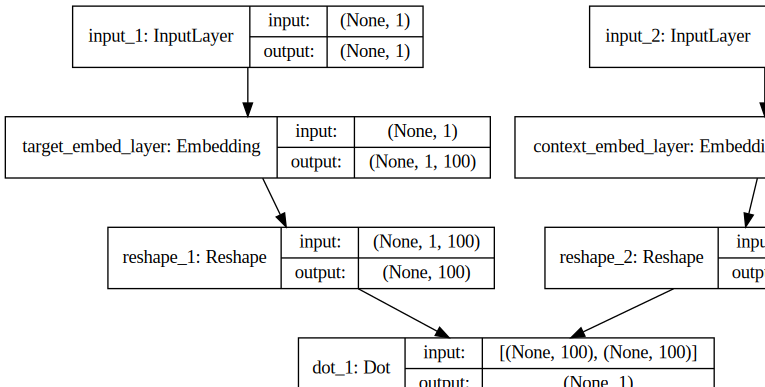

In [0]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True,
show_layer_names=True).create(prog='dot', format='svg'))

6. Training the Model

In [0]:
import numpy as np 
import math

for epoch in range(1, 6):
  epoch_loss = 0
  # in each epoch, train all the sentences, one per iteration=> batch_size = num_sents
  for i, sent_examples in enumerate(skip_grams):
    target_wds = np.array([pair[0] for pair in sent_examples[0]], dtype='int32')
    context_wds = np.array([pair[1] for pair in sent_examples[0]], dtype='int32')
    labels = np.array(sent_examples[1], dtype='int32')
    X = [target_wds, context_wds]
    Y = labels
    if i % 5000 == 0: # after 5000 sentences i.e. 5000 iterations
      print('Processed %d sentences' %i)
    #print(model.train_on_batch(X,Y))
    if math.isnan(model.train_on_batch(X,Y)) == False:
      epoch_loss += model.train_on_batch(X, Y)
  print('Processed all %d sentences' %i)
  print('Epoch:', epoch, 'Loss:', epoch_loss, '\n')


Processed 0 sentences








Processed 5000 sentences
Processed 10000 sentences
Processed 15000 sentences
Processed all 16337 sentences
Epoch: 1 Loss: 2301.1521145842853 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed 15000 sentences
Processed all 16337 sentences
Epoch: 2 Loss: 1750.4311990418137 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed 15000 sentences
Processed all 16337 sentences
Epoch: 3 Loss: 1570.411936851363 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed 15000 sentences
Processed all 16337 sentences
Epoch: 4 Loss: 1459.2819808660465 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed 15000 sentences
Processed all 16337 sentences
Epoch: 5 Loss: 1361.2874622983636 



7. Getting the Word Embeddings

In [0]:
word_embeddings = model.get_layer('target_embed_layer').get_weights()[0][1:] # Recall that 0 was left for padding


Sanity Check

In [0]:
print(word_embeddings.shape)

(10171, 100)


In [0]:
from pandas import DataFrame
print(DataFrame(word_embeddings, index=idx2word.values()).head(10))

             0         1         2   ...        97        98        99
could -0.057503  0.078258 -0.150479  ... -0.125350 -0.040457  0.058685
would -0.072480  0.118796  0.061979  ... -0.228607  0.139279  0.057542
mr    -0.083789  0.132328  0.044928  ... -0.303188 -0.072274  0.103361
mrs    0.159288 -0.003670 -0.197643  ... -0.334622  0.098793  0.016832
must  -0.045403  0.211744  0.069021  ... -0.197327 -0.075032 -0.393683
said   0.068981  0.222880  0.094180  ... -0.345576  0.003286  0.088417
one   -0.163962  0.091581 -0.293868  ...  0.017417  0.027737  0.012774
much  -0.143721  0.106195  0.008758  ... -0.174893 -0.113461 -0.212503
miss   0.055836  0.099174  0.018014  ... -0.159134  0.150408  0.021515
every  0.253846  0.311054  0.002639  ... -0.196641 -0.143397 -0.012405

[10 rows x 100 columns]


8. Measuring Similarity Between Word Pairs

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(word_embeddings)

In [0]:
print(similarity_matrix.shape)


(10171, 10171)


9. Exploring and Visualizing your Word Embeddings using t-SNE
----A. Get the most similar words to the search items in the list below

In [0]:
search_terms = ['man', 'love', 'hatred', 'woman', 'wisdom', 'kindness', 'god', 'man', 'folly', 'fool']

# Get the 5 words most similar to the search terms

In [0]:
similar_words = {term: [idx2word[idx]
for idx in (-1 * similarity_matrix[word2idx[term]-1]).argsort()[1:6] + 1]
for term in search_terms}


print(similar_words)

{'man': ['pleasing', 'remarkably', 'sacrifice', 'description', 'proved'], 'love': ['prospect', 'imagination', 'liking', 'belong', 'connected'], 'hatred': ['desponding', 'snatched', 'flattery', 'informing', 'creations'], 'woman': ['continuing', 'north', 'proud', 'folding', 'suitable'], 'wisdom': ['neighbourly', 'arbour', 'embitter', 'eyelashes', 'pointer'], 'kindness': ['allowed', 'confinement', 'trivial', 'encouragement', 'park'], 'god': ['story', 'earnest', 'scenes', 'rejoice', 'ended'], 'folly': ['interested', 'testimony', 'announced', 'proofs', 'triumph'], 'fool': ['mixed', 'st', 'indebted', 'soften', 'opposing']}


B. Plot the words in the dictionary above using t-SNE https://lvdmaaten.github.io/tsne/
Plot 500 of the word embeddings using the code snippets below:

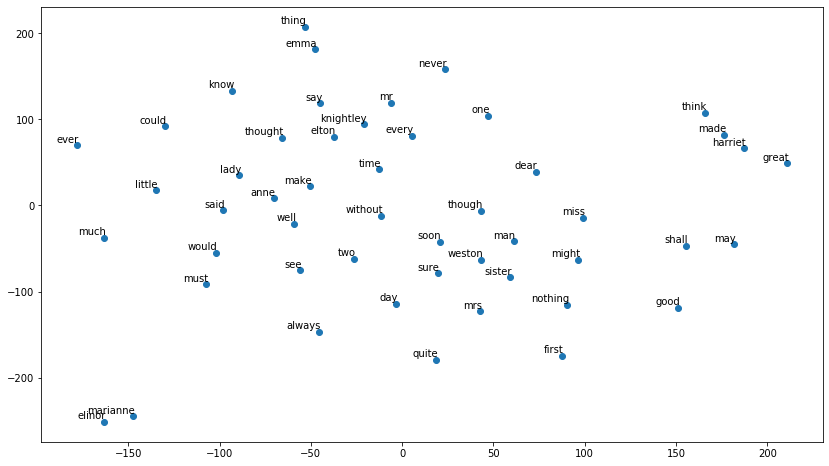

In [0]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50
T = tsne.fit_transform(word_embeddings[:plot_only, :])
labels = [idx2word[i+1] for i in range(plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
  plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')
